<a href="https://colab.research.google.com/github/Jihwan98/2021-2/blob/main/DeepLearning/study/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = Input(shape=img_shape)

In [3]:
# encoder network
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1.)
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [4]:
class CustomVariationalLayer(tensorflow.keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = tensorflow.keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1
    )
    return K.mean(xent_loss + kl_loss)
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

y = CustomVariationalLayer()([input_img, z_decoded])

In [5]:
from tensorflow.keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None, experimental_run_tf_function=False)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32) / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype(np.float32) / 255.
x_test = x_test.reshape(x_test.shape + (1,))

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59968/60000 [============================>.] - ETA: 0s - loss: 0.2135

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 82s 1ms/sample - loss: 0.2135 - val_loss: 0.2004
Epoch 2/10
60000/60000 [==============================] - 46s 771us/sample - loss: 0.1968 - val_loss: 0.1934
Epoch 3/10
60000/60000 [==============================] - 46s 772us/sample - loss: 0.1925 - val_loss: 0.1906
Epoch 4/10
60000/60000 [==============================] - 46s 772us/sample - loss: 0.1901 - val_loss: 0.1894
Epoch 5/10
60000/60000 [==============================] - 46s 771us/sample - loss: 0.1884 - val_loss: 0.1868
Epoch 6/10
60000/60000 [==============================] - 46s 764us/sample - loss: 0.1871 - val_loss: 0.1894
Epoch 7/10
60000/60000 [==============================] - 46s 762us/sample - loss: 0.1861 - val_loss: 0.1862
Epoch 8/10
60000/60000 [==============================] - 46s 763us/sample - loss: 0.1852 - val_loss: 0.1847
Epoch 9/10
60000/60000 [==============================] - 46s 766us/sample - loss: 0.1846 - val_loss: 0.1847
Epoch 10/10
60000/60000 [=======

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


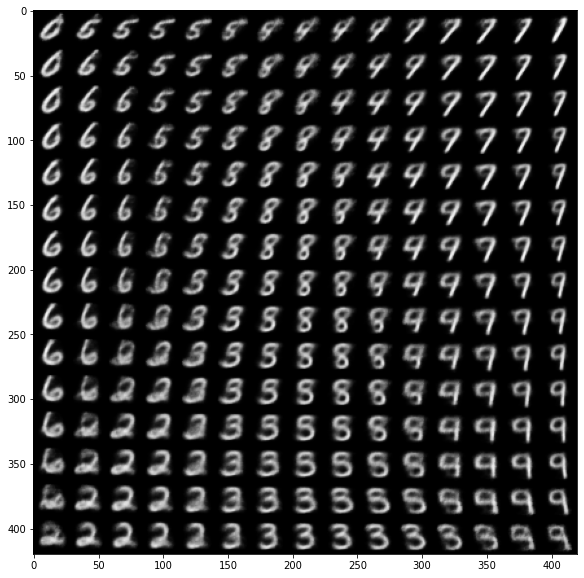

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='gray')
plt.show()